# Team rADAtouille - Milestone 2

This notebook aims to preprocess our data, and estimate the feasibility of the different ideas we had during the first milestone, using data exploration and some preliminary analysis.

On today's menu:
- [Data loading](#Data-loading)
- [Initial dataset preprocessing](#Data-preprocessing)
    - [Characters dataset](#Characters-dataset) 
    - [Movies dataset](#Movies-dataset)
    - [Plot summaries dataset](#Plot-summaries-dataset)
- [External datasets](#External-datasets)
    - [Scrapping Data](#Scrapping-Data)
    - [Scrapped Data Preprocessing](#Scrapped-Data-Preprocessing)
- [Data merging](#Data-merging)
- [Data exploration](#Data-exploration)

# Data loading

First let's do some imports and set up the environment.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's load the provided data by adding the appropriate header and take a look at the first few rows.

In [59]:
# For the characters metadata
character_header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase actor map ID', 'Freebase character ID', 'Freebase actor ID']
df_characters = pd.read_table('data/character.metadata.tsv', names=character_header)

# For the movies metadata
movie_header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
df_movies = pd.read_table('data/movie.metadata.tsv', names=movie_header)

# For the plot summaries
plot_header = ['Wikipedia movie ID', 'Plot summary']
df_plots = pd.read_table('data/plot_summaries.txt', names=plot_header)

In [60]:
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Wikipedia movie ID          450669 non-null  int64  
 1   Freebase movie ID           450669 non-null  object 
 2   Movie release date          440674 non-null  object 
 3   Character name              192794 non-null  object 
 4   Actor date of birth         344524 non-null  object 
 5   Actor gender                405060 non-null  object 
 6   Actor height                154824 non-null  float64
 7   Actor ethnicity             106058 non-null  object 
 8   Actor name                  449441 non-null  object 
 9   Actor age at movie release  292556 non-null  float64
 10  Freebase actor map ID       450669 non-null  object 
 11  Freebase character ID       192804 non-null  object 
 12  Freebase actor ID           449854 non-null  object 
dtypes: float64(2),

# Initial dataset preprocessing

## Characters dataset

Let's check if we can find some missing values in the dataset.

In [61]:
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Wikipedia movie ID          450669 non-null  int64  
 1   Freebase movie ID           450669 non-null  object 
 2   Movie release date          440674 non-null  object 
 3   Character name              192794 non-null  object 
 4   Actor date of birth         344524 non-null  object 
 5   Actor gender                405060 non-null  object 
 6   Actor height                154824 non-null  float64
 7   Actor ethnicity             106058 non-null  object 
 8   Actor name                  449441 non-null  object 
 9   Actor age at movie release  292556 non-null  float64
 10  Freebase actor map ID       450669 non-null  object 
 11  Freebase character ID       192804 non-null  object 
 12  Freebase actor ID           449854 non-null  object 
dtypes: float64(2),

We can identify from the output above that:
- There are some *missing values*
- Some *type are not exploitable* (e.g. the `Movie release date` and `Actor date of birth`  are `object`s, not exploitable dates)

We  first tackle the type problem by converting the `object` type to `datetime` type.

In [62]:
df_characters['Movie release date'].sample(10)

383551          1959
277003          1998
313396    2003-09-03
360222    1997-05-02
51420           1927
194705    1957-12-17
99990     2002-07-09
370329    1977-01-10
112034    1996-06-10
98150           1999
Name: Movie release date, dtype: object

In [63]:
nb_missing_release_date_before = df_characters['Movie release date'].isna().sum()
nb_missing_birth_date_before = df_characters['Actor date of birth'].isna().sum()

# Convert to datetime using the ISO8601 format
df_characters['Movie release date'] = pd.to_datetime(df_characters['Movie release date'], errors='coerce', format='ISO8601')
df_characters['Actor date of birth'] = pd.to_datetime(df_characters['Actor date of birth'], errors='coerce')

print('Have lost %d release dates'%(df_characters['Movie release date'].isna().sum() - nb_missing_release_date_before), 'now there are %d missing'%(df_characters['Movie release date'].isna().sum()))
print('Have lost %d birth dates'%(df_characters['Actor date of birth'].isna().sum() - nb_missing_birth_date_before), 'now there are %d missing'%(df_characters['Actor date of birth'].isna().sum()))

Have lost 15 release dates now there are 10010 missing
Have lost 14637 birth dates now there are 120782 missing


Concerning the *missing values* problem, we have 3 options: not using the problematic columns, dropping the rows or filling the missing values using external source.

Now we'll take a look at the values and see if we can find some outliers.

In [64]:
df_characters.describe(include='all')

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor map ID,Freebase character ID,Freebase actor ID
count,4.506690e+05,450669,440659,192794,329887,405060,154824.000000,106058,449441,292556.000000,450669,192804,449854
unique,NaN,64330,NaN,126629,NaN,2,NaN,479,134078,NaN,450669,183435,135760
top,NaN,/m/0cc8620,NaN,Doctor,NaN,M,NaN,/m/0dryh9k,Mel Blanc,NaN,/m/0bgchxw,/m/0h577m2,/m/0c5vh
freq,NaN,115,NaN,198,NaN,270257,NaN,16351,791,NaN,1,146,791
mean,1.396975e+07,NaN,1984-11-10 22:25:30.832684736,NaN,1943-05-29 11:41:52.427588992,NaN,1.788893,NaN,NaN,37.788523,NaN,NaN,NaN
min,3.300000e+02,NaN,1888-01-01 00:00:00,NaN,1796-09-20 00:00:00,NaN,0.610000,NaN,NaN,-7896.000000,NaN,NaN,NaN
25%,3.759292e+06,NaN,1969-01-01 00:00:00,NaN,1922-09-01 00:00:00,NaN,1.676400,NaN,NaN,28.000000,NaN,NaN,NaN
50%,1.189065e+07,NaN,1994-01-01 00:00:00,NaN,1948-02-25 00:00:00,NaN,1.750000,NaN,NaN,36.000000,NaN,NaN,NaN
75%,2.366501e+07,NaN,2005-08-20 00:00:00,NaN,1966-07-11 00:00:00,NaN,1.830000,NaN,NaN,47.000000,NaN,NaN,NaN
max,3.750192e+07,NaN,2016-06-08 00:00:00,NaN,2011-09-02 00:00:00,NaN,510.000000,NaN,NaN,103.000000,NaN,NaN,NaN


Uh, we can find a few interesting results:
- How can an actors' height be 510m ? 
- How can an actor's age be negative ?

Let's first take a look at the corresponding row for the heigh

In [65]:
df_characters[df_characters['Actor height'] > 2.5]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase actor map ID,Freebase character ID,Freebase actor ID
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
59719,12206655,/m/02vvw24,NaT,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl
104140,17999628,/m/047n_2q,1998-01-01,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0
316621,3915041,/m/0b6lyp,2002-01-01,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl


Using a few google searches, we found that for the 510.0m problem, the actor's height is 5'10" (1.78m). We'll fix this value.
Concerning the 180m problem, we can guess that the actor's height is 1.80m, but we can't find any source to confirm this (internet or other rows). We'll drop these row (4).

In [66]:
# 510 problem: -> replace
df_characters.loc[df_characters['Actor height'] == 510, 'Actor height']=1.78
# 180 problem: -> drop
df_characters.drop(df_characters[df_characters['Actor height'] == 180].index, inplace=True)

Let's then take care of the age problem.

In [67]:
print(df_characters[df_characters['Actor age at movie release'] < 0].shape[0], 'such rows are concerned')
df_characters = df_characters[df_characters['Actor age at movie release'] > 0]

381 such rows are concerned


In [68]:
# Count the number of actor born after the movie release
df_characters[df_characters['Actor date of birth'] > df_characters['Movie release date']].shape[0]

0

This hence not a problem! We also look for duplicates.

In [71]:
df_characters.duplicated(subset=['Wikipedia movie ID', 'Freebase actor map ID']).sum()

0

Seems like there are no duplicates.

We have probably now a cleaner dataset!

## Movie dataset

In [69]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wikipedia movie ID        81741 non-null  int64  
 1   Freebase movie ID         81741 non-null  object 
 2   Movie name                81741 non-null  object 
 3   Movie release date        74839 non-null  object 
 4   Movie box office revenue  8401 non-null   float64
 5   Movie runtime             61291 non-null  float64
 6   Movie languages           81741 non-null  object 
 7   Movie countries           81741 non-null  object 
 8   Movie genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


We have a similar date problem as the one we had with the characters dataset. We'll fix it the same way.

In [72]:
nb_missing_date_before = df_movies['Movie release date'].isna().sum()
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce', format='ISO8601')
print('Have lost %d release dates'%(df_movies['Movie release date'].isna().sum() - nb_missing_date_before), 'now there are %d missing'%(df_movies['Movie release date'].isna().sum()))

Have lost 1 release dates now there are 6903 missing


In [77]:
#Check for duplicate entries
print('Check for duplicate entries:')
print(df_movies.duplicated().sum())

#Check for duplicate entries with name only
print('Check for duplicate entries with name only:')
print(df_movies.duplicated(subset=['Movie name']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and date release:')
print(df_movies.duplicated(subset=['Movie name', 'Movie release date']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with name and movie runtime:')
print(df_movies.duplicated(subset=['Movie name', 'Movie runtime']).sum())

#Check for duplicate entries with name and date release only
print('Check for duplicate entries with wikipedia ID:')
print(df_movies.duplicated(subset=['Wikipedia movie ID']).sum())

Check for duplicate entries:
0
Check for duplicate entries with name only:
6263
Check for duplicate entries with name and date release:
103
Check for duplicate entries with name and movie runtime:
628
Check for duplicate entries with wikipedia ID:
0


In [ ]:
print(df_characters[df_characters['Actor age at movie release'] < 0].shape[0], 'such rows are concerned')
df_characters = df_characters[df_characters['Actor age at movie release'] > 0]

381 such rows are concerned


We have some duplicate entries on the name but the wikipedia ID is always unique

In [78]:
df_movies.describe(include='all')

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
count,8.174100e+04,81741,81741,74838,8.401000e+03,6.129100e+04,81741,81741,81741
unique,NaN,81741,75478,NaN,NaN,NaN,1817,2124,23817
top,NaN,/m/03vyhn,Alice in Wonderland,NaN,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
freq,NaN,1,17,NaN,NaN,NaN,33748,30300,6851
mean,1.740784e+07,NaN,NaN,1977-10-12 11:46:07.610037696,4.799363e+07,1.118192e+02,NaN,NaN,NaN
min,3.300000e+02,NaN,NaN,1888-01-01 00:00:00,1.000000e+04,0.000000e+00,NaN,NaN,NaN
25%,7.323695e+06,NaN,NaN,1956-01-01 00:00:00,2.083193e+06,8.100000e+01,NaN,NaN,NaN
50%,1.777899e+07,NaN,NaN,1985-05-18 12:00:00,1.063969e+07,9.300000e+01,NaN,NaN,NaN
75%,2.715573e+07,NaN,NaN,2004-01-01 00:00:00,4.071696e+07,1.060000e+02,NaN,NaN,NaN
max,3.750192e+07,NaN,NaN,2016-06-08 00:00:00,2.782275e+09,1.079281e+06,NaN,NaN,NaN


Looking at the output, we may have a few observations:
- Is there a problem with the `Movie release date` column ? There is at least one entry with a date in the future compared to when the dataset was released.
- 2B in box office revenue seems a bit excessive, according to Google the max is around 380M$. 
- The `Movie runtime` column seems to have some outliers, with at least one movie with a runtime of 0, and one of 1 million minutes (multiple months).

<AxesSubplot: title={'center': 'Distribution of movie release date'}, xlabel='Movie release date', ylabel='Count'>

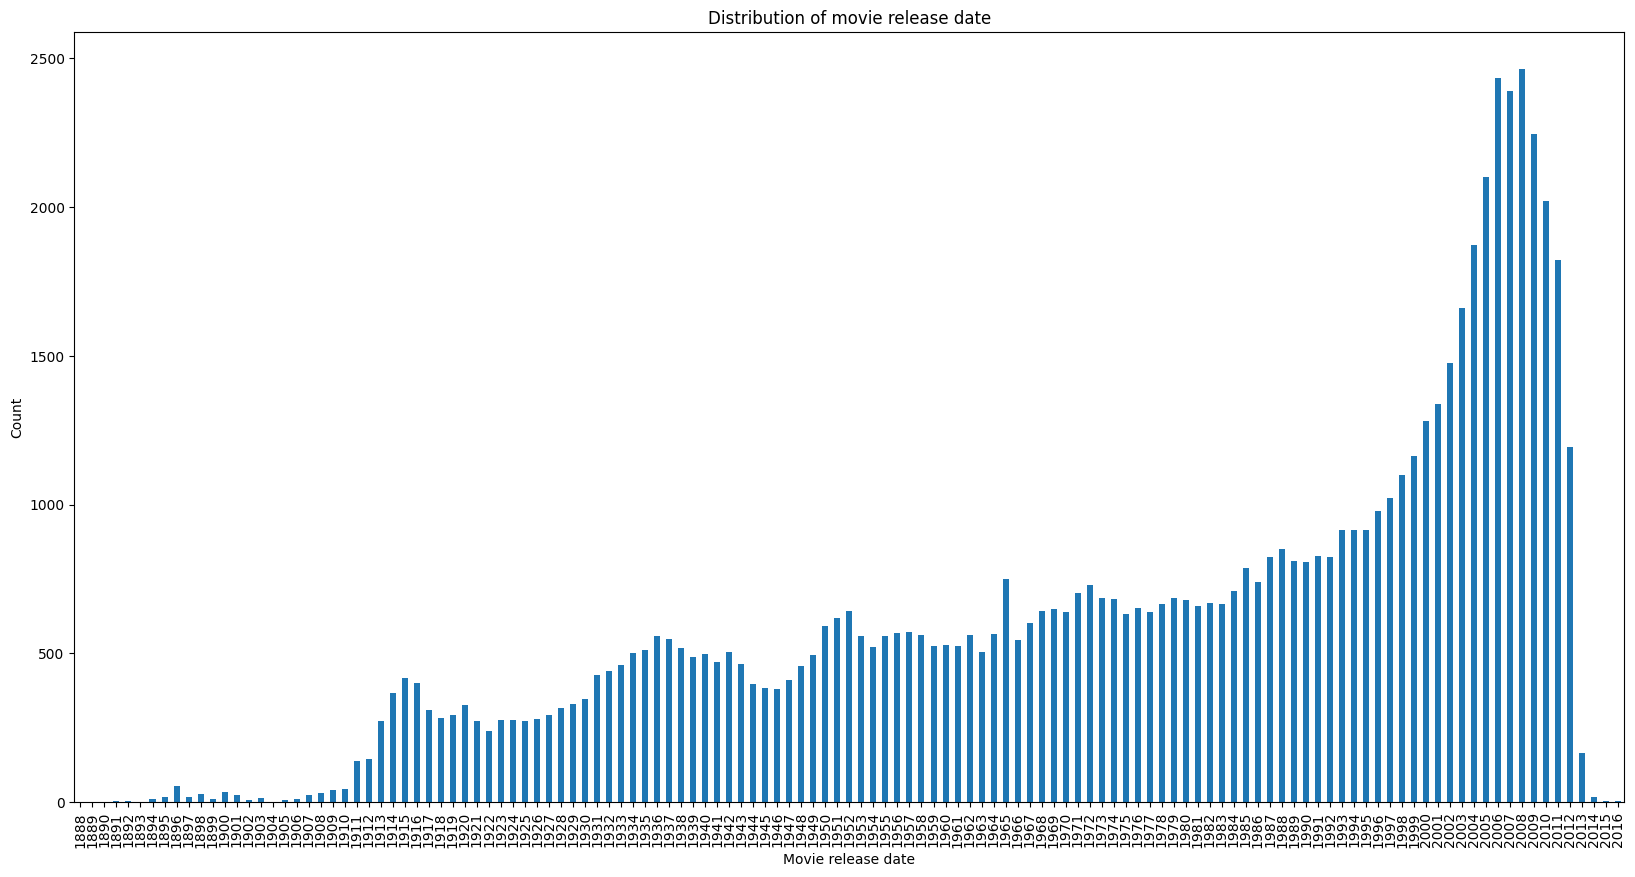

In [82]:
# Plot the distribution of the movie release date
plt.figure(figsize=(20, 10))
plt.title('Distribution of movie release date')
plt.xlabel('Movie release date')
plt.ylabel('Count')
df_movies.dropna(subset=['Movie release date'])['Movie release date'].dt.year.sort_values().value_counts(sort=False).plot(kind='bar')

In [84]:
df_movies[df_movies['Movie release date'] > pd.to_datetime('2014')]

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
2768,35343769,/m/0j9qc6b,Gokula Krishna,2014-04-02,NaN,NaN,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D..."
8307,24179103,/m/0jwx0kc,"I, Robot 2",2015-01-01,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction""}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016-03-18,NaN,NaN,{},{},{}
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016-06-08,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"
34454,35764246,/m/0jt01_6,Appayya,2014-08-15,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}"
34896,36534974,/m/0kdy118,Noah,2014-03-28,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01hmnh"": ""Fantasy""}"
40166,2312141,/m/072zwn,Knight Rider: The Movie,2015-01-01,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06n90"": ""Sci..."
51429,25813358,/m/0gmbk1g,Avatar 2,2015-01-01,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
52234,35042288,/m/0j630fh,Bulbul,2014-07-01,NaN,NaN,"{""/m/09bnf"": ""Kannada Language""}","{""/m/03rk0"": ""India""}",{}
53855,32416903,/m/0gys9tc,Total Dhamaal,2015-01-01,NaN,138.0,"{""/m/03k50"": ""Hindi Language""}",{},"{""/m/05p553"": ""Comedy film""}"


In [87]:
df_movies[df_movies['Movie release date'] > pd.to_datetime('2014')].shape[0]

14

We can see that there are 14 occurence of movies that were released after the release of the dataset. In order to have a more representative dataset, we'll drop these rows.

In [88]:
df_movies = df_movies[df_movies['Movie release date'] < pd.to_datetime('2014')]

<AxesSubplot: title={'center': 'Log distribution of movie runtime'}, xlabel='Movie runtime', ylabel='Count'>

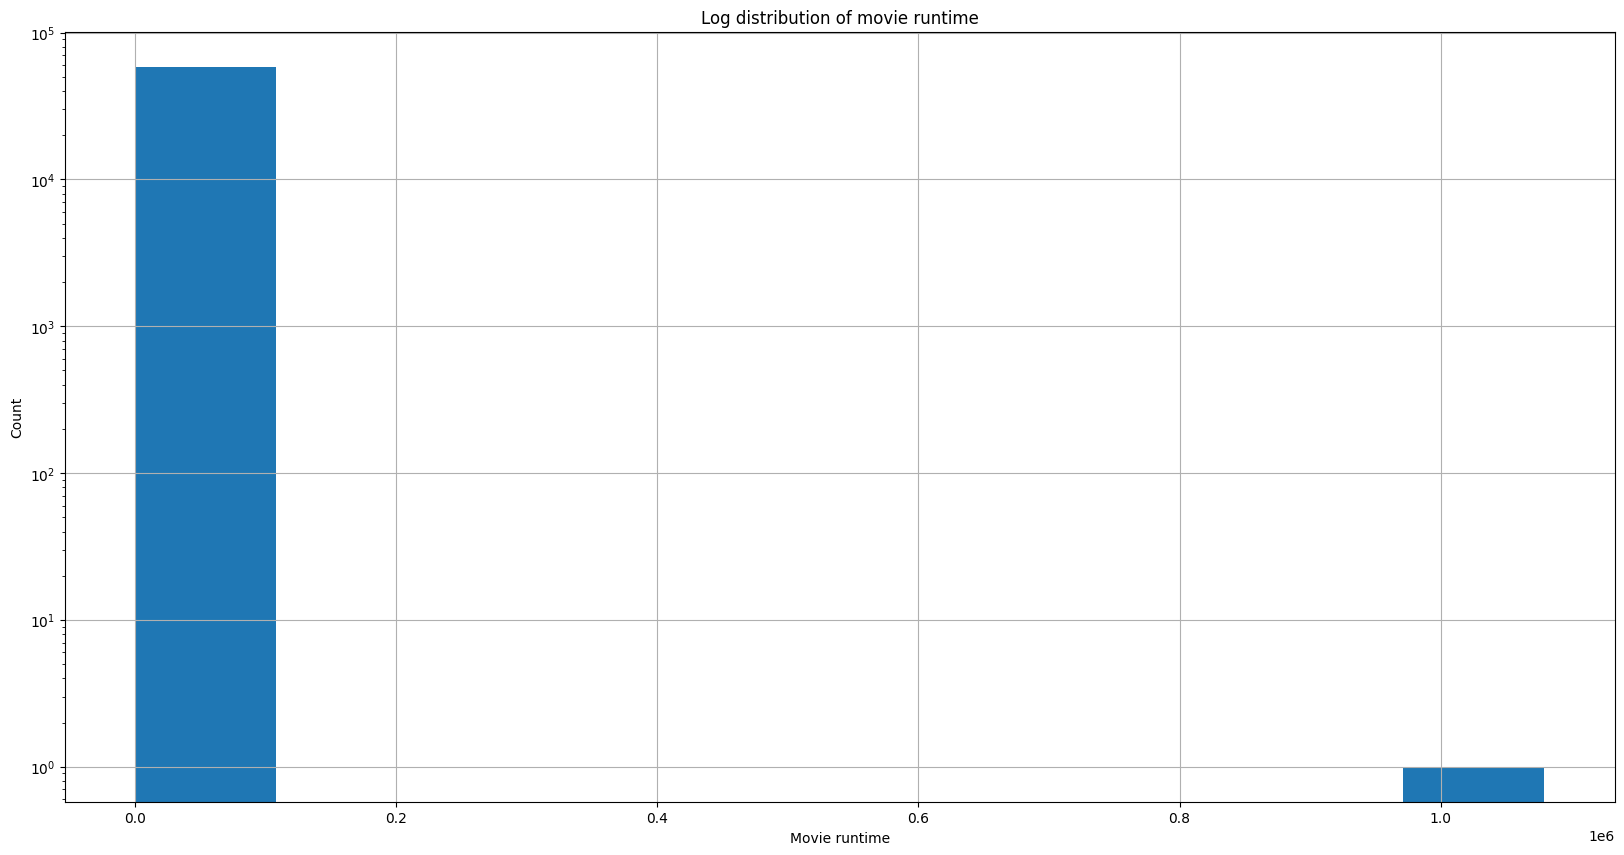

In [89]:
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Movie runtime')
plt.ylabel('Count')
plt.yscale('log')
df_movies.dropna(subset=['Movie runtime'])['Movie runtime'].hist(bins=10)

In [96]:
df_movies = df_movies[df_movies['Movie runtime'] < 5000]

<AxesSubplot: title={'center': 'Log distribution of movie runtime'}, xlabel='Movie runtime', ylabel='Count'>

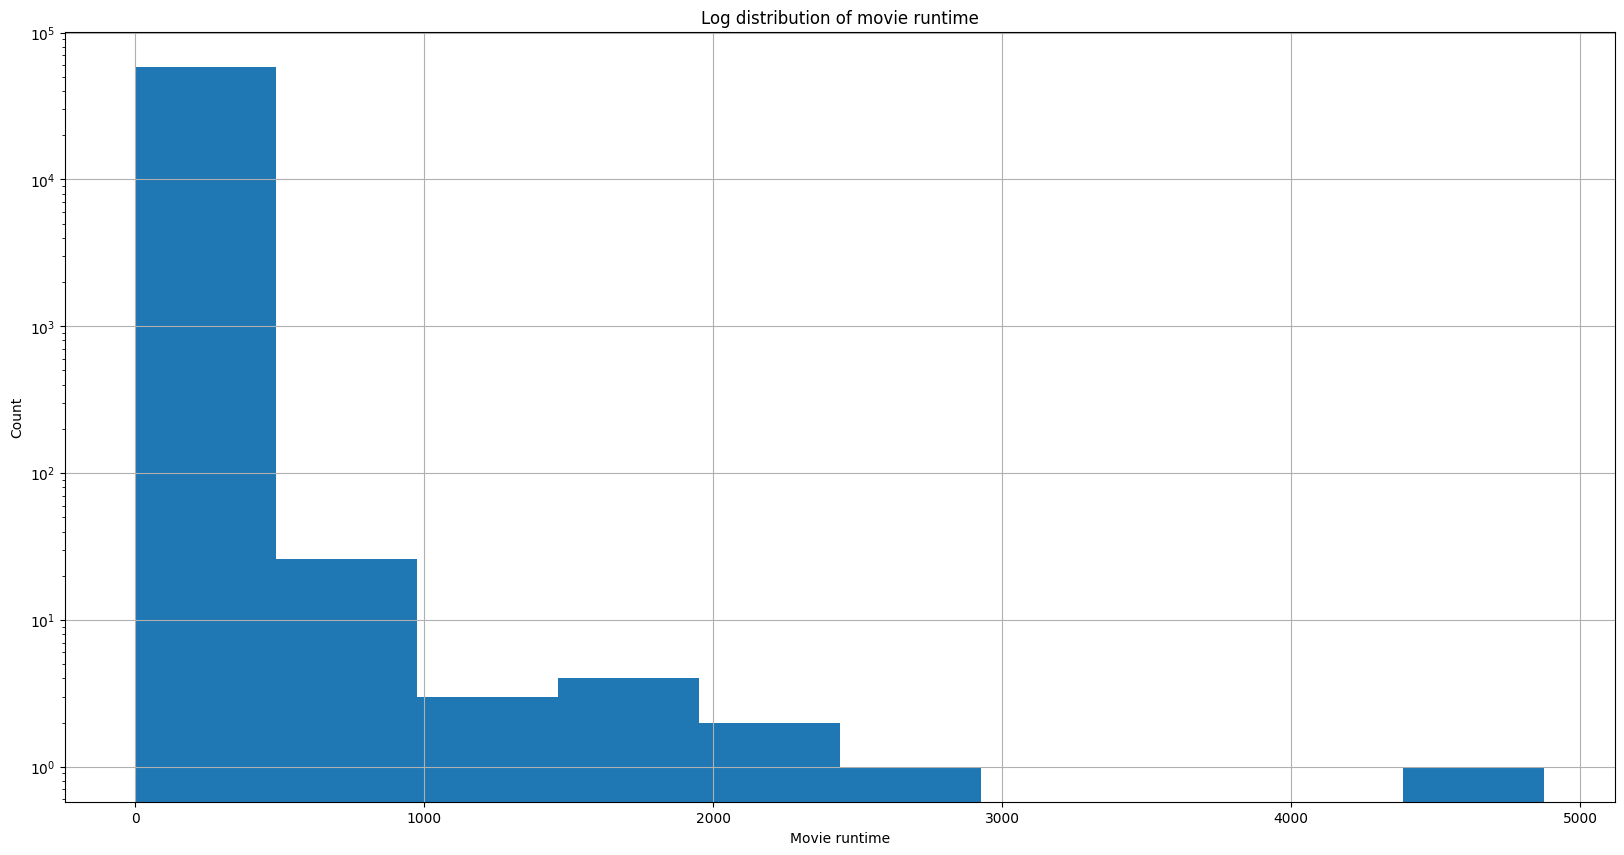

In [97]:
plt.figure(figsize=(20,10))
plt.title('Log distribution of movie runtime')
plt.xlabel('Movie runtime')
plt.ylabel('Count')
plt.yscale('log')
df_movies.dropna(subset=['Movie runtime'])['Movie runtime'].hist(bins=10)

Euh wallah jsp quoi faire mon khoya, maybe la méthode des IQR mais on risque de perdre les films expérimentaux

## Plot summaries dataset

In [98]:
df_plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42303 entries, 0 to 42302
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Wikipedia movie ID  42303 non-null  int64 
 1   Plot summary        42303 non-null  object
dtypes: int64(1), object(1)
memory usage: 661.1+ KB


In [114]:
df_plots.duplicated(subset=['Plot summary']).sum()

8

In [116]:
df_plots[df_plots.duplicated(subset=['Plot summary'])]

,Wikipedia movie ID,Plot summary
14631,14055212,A woman is thrown out of her home by her jealo...
29428,14022275,A woman is thrown out of her home by her jealo...
30987,14051944,A woman is thrown out of her home by her jealo...
31702,14053389,A woman is thrown out of her home by her jealo...
35058,19609453,Raja was adopted by a criminal don at a very ...
38536,14616220,"As the American Civil War begins, Ned Burton l..."
38831,10791937,Taking a step aside from the usual serious dra...
39019,29481480,An orphan Raghav turns into a ruthless contrac...


There seems to be some duplicated values, aka some movies with the same plot summary. 

# External datasets

As our project require more data than provided, we needed some external data.
- IMDB user reviews
- Critics reviews and ratings (Metascore)
- Awards and nominations:
    - [Oscar](https://en.wikipedia.org/wiki/Academy_Awards)
    - [Cesar](https://en.wikipedia.org/wiki/C%C3%A9sar_Awards)
    - [Golden Globes](https://en.wikipedia.org/wiki/Golden_Globe_Awards)
    - [Cannes](https://en.wikipedia.org/wiki/Cannes_Film_Festival)
    - [Toronto](https://en.wikipedia.org/wiki/Toronto_International_Film_Festival)
    - [Venice](https://en.wikipedia.org/wiki/Venice_Film_Festival)
    - [Locarno](https://en.wikipedia.org/wiki/Locarno_Film_Festival)
    - Total number of nominations: using IMDB's website data

## Scrapping Data


The website [imdb.com](https://www.imdb.com/) (Internet Movie Data base) contains most of the needed data (Every single needed external data, but not the critics ratings and reviews, that we can find on the metacritic website). We won't describe here the scrapping process, but all the code is available in the [scrap.ipynb](./scrap.ipynb) file.

We will now load and describe the scrapped data.

In [123]:
# TODO: remove the todo

## Scrapped Data Preprocessing

# Data merging


# Data exploration